In [3]:
import sys
sys.path.append('/workspace/bayes3d/')
sys.path.append('/workspace/diff-dope')

In [2]:
!pip install plyfile fvcore
!pip install --no-index pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt1131/download.html

In [22]:
### install diffdope as needed
# !pip install -e '/workspace/diff-dope'
# !pip install opencv-python==4.8.0.74

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for opencv-python==4.8.0.74 from https://files.pythonhosted.org/packages/34/7c/8a5043f362b0a55f07812a0db3f86092cdbd0fe41b933d7bc6fce3ab6c15/opencv_python-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 165.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [12]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import bayes3d as b
from tqdm import tqdm
import jax.numpy as jnp
import pytorch3d
import pytorch3d.transforms as t3d
import bayes3d._rendering.nvdiffrast_full.nvdiffrast.torch as dr
import bayes3d._rendering.diffdope as dd
from PIL import Image, ImageOps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
b.t3d # sanity check import
b.camera

<module 'bayes3d.camera' from '/workspace/bayes3d/bayes3d/camera.py'>

In [14]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 1e-3
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = [200,200]
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [15]:
# Misc helpers
def get_img_with_border(img, border=5, fill='red'):
    cropped_img = ImageOps.crop(img, border=border)
    return ImageOps.expand(cropped_img, border=border,fill=fill)


def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(0)

Random seed set as 0


In [16]:
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()

In [17]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

# m = b.utils.make_cuboid_mesh(jnp.array([0.5, 0.5, 0.2]))

vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()
# print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))
print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
print(vtx_pos, vtx_col)

torch.Size([15728, 3]) torch.Size([16763, 3]) torch.Size([16763, 3]) torch.Size([1, 3])
tensor([[-0.4248, -0.2584, -0.3477],
        [-0.4334, -0.2500, -0.3395],
        [-0.4441, -0.2338, -0.3527],
        ...,
        [ 0.4904, -0.0145,  0.2256],
        [ 0.3056, -0.0512,  0.2582],
        [ 0.3417, -0.0483,  0.3824]], device='cuda:0') tensor([[1., 1., 1.]], device='cuda:0')


In [18]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)

mvp = proj_cam = torch.tensor(np.array(b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)), device=device, dtype=torch.float32)  # model-view-projection transformation
mvp

tensor([[ 2.0000,  0.0000,  0.0050,  0.0000],
        [ 0.0000,  2.0000,  0.0050,  0.0000],
        [ 0.0000,  0.0000,  1.0036, -0.0200],
        [ 0.0000,  0.0000,  1.0000,  0.0000]], device='cuda:0')

In [19]:
def posevec_to_matrix_single(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )

def posevec_to_matrix_batch(positions, quats):
    batch_size = positions.shape[0]
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quats), positions.unsqueeze(2)), 2),
            torch.tensor([0.0, 0.0, 0.0, 1.0], device=device).repeat(batch_size,1,1),
        ),
        1,
    )

In [20]:
def render(pos, quat):
    # express as 4x4 rotation matrix
    rot_mtx_44 = posevec_to_matrix_single(pos, quat)

    # preprocess and transform points into clip space
    pos = vtx_pos[None,...].contiguous()
    posw = torch.cat([pos, torch.ones([pos.shape[0], pos.shape[1], 1]).cuda()], axis=2)  # (xyz) -> (xyz1)
    transform_mtx = torch.matmul(proj_cam, rot_mtx_44)  # transform = projection + pose rotation
    pos_clip_ja = dd.xfm_points(pos, transform_mtx[None,...])  # transform points
    
    # rasterize and interpolate (in world space)
    rast_out, rast_out_db = dr.rasterize(glctx, pos_clip_ja, pos_idx, resolution=resolution)
    gb_pos, _ = dr.interpolate(posw, rast_out, pos_idx, rast_db=rast_out_db)
    
    # Get depth values (in camera space)
    gb_pos = gb_pos.contiguous()
    mask= rast_out[...,2] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = dd.xfm_points(gb_pos, rot_mtx_44[None,...])
    depth = depth.reshape(shape_keep)[..., 2] * -1

    return depth, mask

def render_batch(pos, quat):
    # express as 4x4 rotation matrix
    rot_mtx_44 = posevec_to_matrix_batch(pos, quat)
    
    # preprocess and transform points into clip space
    pos = vtx_pos[None,...].contiguous()
    posw = torch.cat([pos, torch.ones([pos.shape[0], pos.shape[1], 1]).cuda()], axis=2)  # (xyz) -> (xyz1)
    transform_mtx = torch.matmul(proj_cam, rot_mtx_44)  # transform = projection + pose rotation
    pos_clip_ja = dd.xfm_points(pos, transform_mtx)  # transform points
    
    # rasterize and interpolate (in world space)
    rast_out, rast_out_db = dr.rasterize(glctx, pos_clip_ja, pos_idx, resolution=resolution)
    gb_pos, _ = dr.interpolate(posw, rast_out, pos_idx, rast_db=rast_out_db)

    # Get depth values (in camera space)
    gb_pos = gb_pos.contiguous()
    mask= rast_out[...,2] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = dd.xfm_points(gb_pos, rot_mtx_44)
    depth = depth.reshape(shape_keep)[..., 2] * -1

    return depth, mask

## Single hypo GD

In [21]:
set_seed(0)

Random seed set as 0


/tmp/ipykernel_1103/3927362685.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
Using /root/.cache/torch_extensions/py310_cu122 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu122/renderutils_plugin/build.ninja...
Building extension module renderutils_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module renderutils_plugin...


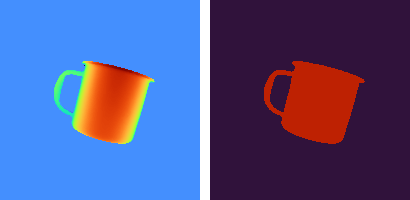

/tmp/ipykernel_1103/3927362685.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)


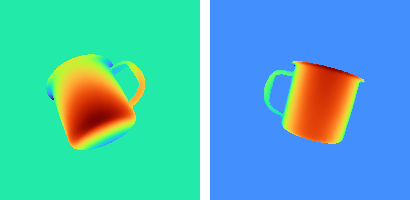

In [22]:
pos = torch.tensor([0.0, 0.0, 2.5],device=device)
quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
obs_depth, mask_gt = render(pos, quat)
viz_gt = b.get_depth_image(jnp.array(obs_depth[0].cpu().numpy()))
viz_mask_gt = b.get_depth_image(jnp.array(mask_gt[0].cpu().numpy()) * 1.0,max=1.1)
b.viz.hstack_images([viz_gt,viz_mask_gt]).show()

pos = torch.tensor([0.0, 0.0,2.4],device=device, requires_grad=True)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)
rendered_image,_ = render(pos,quat)
viz =  b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy()))
b.hstack_images([viz, viz_gt]).show()

In [24]:
def single_gd(it=20000):
    optimizer = torch.optim.Adam([pos], betas=(0.9, 0.999), lr=1e-5)
    optimizer2 = torch.optim.Adam([quat], betas=(0.9, 0.999), lr=1e-4)
    
    pbar = tqdm(range(it))
    for it in pbar:
        rendered_image, _ = render(pos,quat)
        loss = torch.abs((obs_depth - rendered_image) * mask_gt).mean()
        optimizer.zero_grad()
        optimizer2.zero_grad()

        loss.backward()

        optimizer.step()
        optimizer2.step()

        if it % 200 == 0:
            b.hstack_images([b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy())), viz_gt]).show()

        pbar.set_description(f"{loss.item()}")
    viz =  b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy()))
    b.hstack_images([viz, viz_gt])
    
# single_gd()

## Multi hypo GD

In [25]:
set_seed(0)

Random seed set as 0


/tmp/ipykernel_1103/667231488.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat = quat_gt = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)


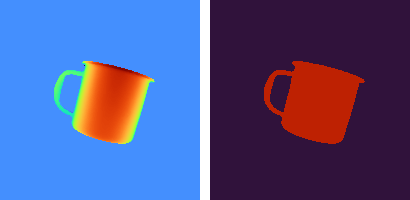

/tmp/ipykernel_1103/667231488.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(num_hypos, 4,device=device) - 0.5,device=device, requires_grad=True)


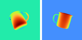

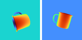

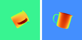

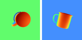

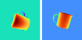

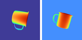

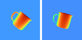

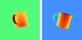

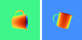

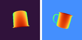

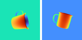

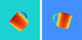

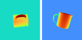

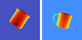

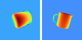

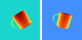

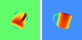

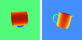

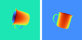

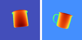

In [26]:
# Ground Truth
pos = pos_gt = torch.tensor([0.0, 0.0, 2.5],device=device)
quat = quat_gt = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
obs_depth, mask_gt = render(pos, quat)
viz_gt = b.get_depth_image(jnp.array(obs_depth[0].cpu().numpy()))
viz_mask_gt = b.get_depth_image(jnp.array(mask_gt[0].cpu().numpy()) * 1.0,max=1.1)
b.viz.hstack_images([viz_gt,viz_mask_gt]).show()

# Hypotheses
num_hypos = 20
pos = torch.tensor([[0.0, 0.0, 2.4] for _ in range(num_hypos)],device=device, requires_grad=True)
quat =  torch.tensor(torch.rand(num_hypos, 4,device=device) - 0.5,device=device, requires_grad=True)

rendered_images, _ = render_batch(pos,quat)
for rendered_image in rendered_images:
    viz =  b.get_depth_image(jnp.array(rendered_image.detach().cpu().numpy()))
    b.scale_image(b.hstack_images([viz, viz_gt]),0.2).show()

  0%|                                                                                           | 0/500 [00:00<?, ?it/s]

new best hypothesis: 6


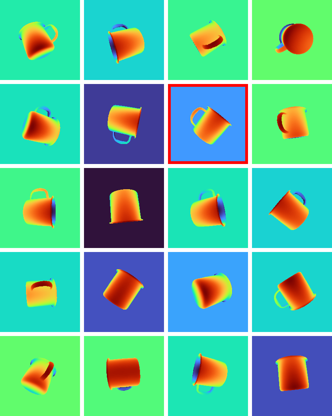

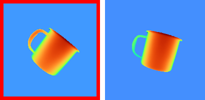

0.3224211633205414:   8%|█████                                                         | 41/500 [00:02<00:26, 17.02it/s]

new best hypothesis: 7


0.2102886140346527:  25%|███████████████                                              | 123/500 [00:07<00:22, 17.12it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 6


0.1955847442150116:  27%|████████████████▍                                            | 135/500 [00:08<00:21, 17.14it/s]

new best hypothesis: 12


0.19048982858657837:  28%|████████████████▋                                           | 139/500 [00:08<00:21, 17.04it/s]

new best hypothesis: 6


0.1856222152709961:  29%|█████████████████▍                                           | 143/500 [00:08<00:20, 17.05it/s]

new best hypothesis: 12


0.18111510574817657:  29%|█████████████████▋                                          | 147/500 [00:09<00:20, 17.04it/s]

new best hypothesis: 6


0.15384094417095184:  40%|███████████████████████▉                                    | 199/500 [00:12<00:17, 17.05it/s]

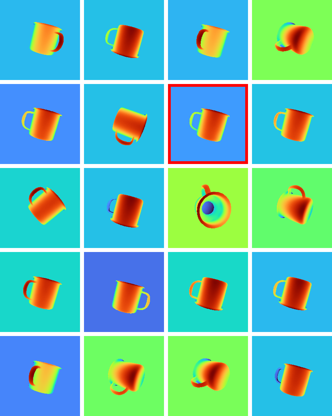

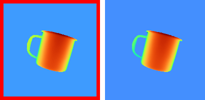

0.12922139465808868:  45%|███████████████████████████▏                                | 227/500 [00:13<00:16, 16.98it/s]

new best hypothesis: 7


0.12659582495689392:  47%|████████████████████████████▏                               | 235/500 [00:14<00:15, 16.98it/s]

new best hypothesis: 6


0.1249317079782486:  48%|█████████████████████████████▏                               | 239/500 [00:14<00:15, 17.02it/s]

new best hypothesis: 4
new best hypothesis: 6


0.12356989085674286:  49%|█████████████████████████████▏                              | 243/500 [00:14<00:15, 16.94it/s]

new best hypothesis: 7
new best hypothesis: 6
new best hypothesis: 7


0.12215568870306015:  49%|█████████████████████████████▋                              | 247/500 [00:14<00:14, 17.00it/s]

new best hypothesis: 6


0.1207004114985466:  50%|██████████████████████████████▌                              | 251/500 [00:15<00:14, 17.06it/s]

new best hypothesis: 4
new best hypothesis: 7


0.11937752366065979:  51%|██████████████████████████████▌                             | 255/500 [00:15<00:14, 17.12it/s]

new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 4


0.11845096945762634:  52%|███████████████████████████████                             | 259/500 [00:15<00:14, 17.05it/s]

new best hypothesis: 6
new best hypothesis: 7


0.11704187095165253:  53%|███████████████████████████████▌                            | 263/500 [00:15<00:13, 17.02it/s]

new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 7


0.11625537276268005:  53%|████████████████████████████████                            | 267/500 [00:16<00:13, 17.11it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4


0.11498644948005676:  54%|████████████████████████████████▌                           | 271/500 [00:16<00:13, 16.95it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 6
new best hypothesis: 7


0.11388258635997772:  55%|█████████████████████████████████                           | 275/500 [00:16<00:13, 16.84it/s]

new best hypothesis: 4
new best hypothesis: 6
new best hypothesis: 7


0.11286979913711548:  56%|█████████████████████████████████▍                          | 279/500 [00:16<00:13, 16.83it/s]

new best hypothesis: 4


0.11160759627819061:  57%|█████████████████████████████████▉                          | 283/500 [00:17<00:12, 16.79it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4


0.11092782020568848:  57%|██████████████████████████████████▍                         | 287/500 [00:17<00:12, 16.86it/s]

new best hypothesis: 7


0.10932692140340805:  59%|███████████████████████████████████▍                        | 295/500 [00:17<00:12, 17.00it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 6


0.10819972306489944:  60%|███████████████████████████████████▉                        | 299/500 [00:17<00:11, 17.09it/s]

new best hypothesis: 7
new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4


0.10759617388248444:  61%|████████████████████████████████████▎                       | 303/500 [00:18<00:11, 16.99it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4


0.10672596096992493:  61%|████████████████████████████████████▊                       | 307/500 [00:18<00:11, 17.04it/s]

new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 6


0.10575861483812332:  62%|█████████████████████████████████████▎                      | 311/500 [00:18<00:11, 17.06it/s]

new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 4


0.10524912178516388:  63%|█████████████████████████████████████▊                      | 315/500 [00:18<00:10, 17.03it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 6


0.10453701764345169:  64%|██████████████████████████████████████▎                     | 319/500 [00:19<00:10, 17.07it/s]

new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 6


0.10367907583713531:  65%|██████████████████████████████████████▊                     | 323/500 [00:19<00:10, 17.05it/s]

new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 4


0.1024075523018837:  66%|████████████████████████████████████████▏                    | 329/500 [00:19<00:10, 16.98it/s]

new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 7


0.10145410150289536:  67%|███████████████████████████████████████▉                    | 333/500 [00:19<00:09, 17.09it/s]

new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 4


0.10084688663482666:  67%|████████████████████████████████████████▍                   | 337/500 [00:20<00:09, 17.08it/s]

new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 6


0.10078846663236618:  68%|████████████████████████████████████████▉                   | 341/500 [00:20<00:09, 17.08it/s]

new best hypothesis: 7
new best hypothesis: 6
new best hypothesis: 4


0.10030648112297058:  69%|█████████████████████████████████████████▍                  | 345/500 [00:20<00:09, 17.09it/s]

new best hypothesis: 12
new best hypothesis: 4
new best hypothesis: 7


0.09964552521705627:  70%|█████████████████████████████████████████▉                  | 349/500 [00:20<00:08, 16.96it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4


0.09924087673425674:  71%|██████████████████████████████████████████▎                 | 353/500 [00:21<00:08, 17.02it/s]

new best hypothesis: 7
new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4


0.09874013066291809:  71%|██████████████████████████████████████████▊                 | 357/500 [00:21<00:08, 17.06it/s]

new best hypothesis: 6
new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 6


0.09819947928190231:  73%|███████████████████████████████████████████▌                | 363/500 [00:21<00:08, 17.08it/s]

new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 19


0.09791671484708786:  73%|████████████████████████████████████████████                | 367/500 [00:21<00:07, 17.04it/s]

new best hypothesis: 4
new best hypothesis: 12
new best hypothesis: 7
new best hypothesis: 4


0.09742804616689682:  74%|████████████████████████████████████████████▌               | 371/500 [00:22<00:07, 17.03it/s]

new best hypothesis: 6
new best hypothesis: 12
new best hypothesis: 6
new best hypothesis: 12


0.0972381979227066:  75%|█████████████████████████████████████████████▊               | 375/500 [00:22<00:07, 17.12it/s]

new best hypothesis: 4
new best hypothesis: 6
new best hypothesis: 4


0.0970388799905777:  76%|██████████████████████████████████████████████▏              | 379/500 [00:22<00:07, 17.08it/s]

new best hypothesis: 19
new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 2


0.0967654138803482:  77%|██████████████████████████████████████████████▋              | 383/500 [00:22<00:06, 17.09it/s]

new best hypothesis: 6
new best hypothesis: 12
new best hypothesis: 19
new best hypothesis: 7


0.09654118865728378:  77%|██████████████████████████████████████████████▍             | 387/500 [00:23<00:06, 17.06it/s]

new best hypothesis: 4
new best hypothesis: 12
new best hypothesis: 7


0.09612509608268738:  79%|███████████████████████████████████████████████▏            | 393/500 [00:23<00:06, 17.12it/s]

new best hypothesis: 19
new best hypothesis: 4
new best hypothesis: 7


0.09598877280950546:  79%|███████████████████████████████████████████████▋            | 397/500 [00:23<00:06, 16.99it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 4
new best hypothesis: 7


0.09580126404762268:  80%|███████████████████████████████████████████████▉            | 399/500 [00:23<00:05, 17.02it/s]

new best hypothesis: 6
new best hypothesis: 4


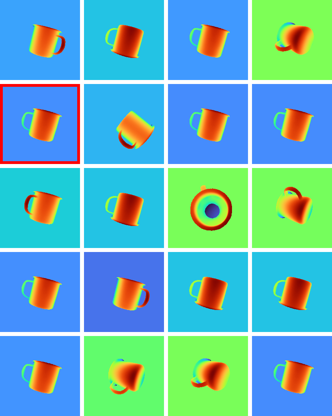

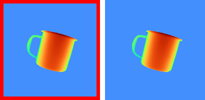

0.09565364569425583:  80%|████████████████████████████████████████████████            | 401/500 [00:23<00:06, 16.45it/s]

new best hypothesis: 7


0.09542831778526306:  81%|████████████████████████████████████████████████▎           | 403/500 [00:24<00:05, 16.49it/s]

new best hypothesis: 4


0.09550662338733673:  81%|████████████████████████████████████████████████▌           | 405/500 [00:24<00:05, 16.72it/s]

new best hypothesis: 12


0.09527488052845001:  81%|████████████████████████████████████████████████▊           | 407/500 [00:24<00:05, 16.77it/s]

new best hypothesis: 4


0.09513511508703232:  82%|█████████████████████████████████████████████████           | 409/500 [00:24<00:05, 16.89it/s]

new best hypothesis: 12


0.09481046348810196:  82%|█████████████████████████████████████████████████▎          | 411/500 [00:24<00:05, 16.92it/s]

new best hypothesis: 19
new best hypothesis: 16
new best hypothesis: 4


0.09477787464857101:  83%|█████████████████████████████████████████████████▌          | 413/500 [00:24<00:05, 16.92it/s]

new best hypothesis: 19


0.09455867856740952:  83%|█████████████████████████████████████████████████▊          | 415/500 [00:24<00:05, 16.93it/s]

new best hypothesis: 4
new best hypothesis: 19


0.09434855729341507:  83%|██████████████████████████████████████████████████          | 417/500 [00:24<00:04, 17.02it/s]

new best hypothesis: 7


0.09408026188611984:  84%|██████████████████████████████████████████████████▎         | 419/500 [00:25<00:04, 16.96it/s]

new best hypothesis: 4
new best hypothesis: 19


0.09375713020563126:  84%|██████████████████████████████████████████████████▌         | 421/500 [00:25<00:04, 17.00it/s]

new best hypothesis: 7


0.09336616098880768:  85%|██████████████████████████████████████████████████▊         | 423/500 [00:25<00:04, 17.02it/s]

new best hypothesis: 4
new best hypothesis: 19
new best hypothesis: 6


0.09320272505283356:  85%|███████████████████████████████████████████████████         | 425/500 [00:25<00:04, 17.01it/s]

new best hypothesis: 4


0.09328480809926987:  85%|███████████████████████████████████████████████████▏        | 427/500 [00:25<00:04, 17.01it/s]

new best hypothesis: 19
new best hypothesis: 2
new best hypothesis: 4


0.09341582655906677:  86%|███████████████████████████████████████████████████▍        | 429/500 [00:25<00:04, 17.07it/s]

new best hypothesis: 6


0.0933893695473671:  86%|████████████████████████████████████████████████████▌        | 431/500 [00:25<00:04, 16.99it/s]

new best hypothesis: 4


0.09329446405172348:  87%|████████████████████████████████████████████████████▏       | 435/500 [00:25<00:03, 17.06it/s]

new best hypothesis: 19
new best hypothesis: 4


0.09303896874189377:  88%|████████████████████████████████████████████████████▋       | 439/500 [00:26<00:03, 17.08it/s]

new best hypothesis: 12
new best hypothesis: 6
new best hypothesis: 4


0.09307140111923218:  89%|█████████████████████████████████████████████████████▏      | 443/500 [00:26<00:03, 17.06it/s]

new best hypothesis: 7
new best hypothesis: 19
new best hypothesis: 4


0.09315156936645508:  89%|█████████████████████████████████████████████████████▋      | 447/500 [00:26<00:03, 17.13it/s]

new best hypothesis: 7
new best hypothesis: 19
new best hypothesis: 4
new best hypothesis: 7


0.09320821613073349:  91%|██████████████████████████████████████████████████████▎     | 453/500 [00:26<00:02, 17.15it/s]

new best hypothesis: 6
new best hypothesis: 7


0.09299545735120773:  91%|██████████████████████████████████████████████████████▊     | 457/500 [00:27<00:02, 17.04it/s]

new best hypothesis: 12
new best hypothesis: 4
new best hypothesis: 19


0.09315836429595947:  92%|███████████████████████████████████████████████████████▎    | 461/500 [00:27<00:02, 17.06it/s]

new best hypothesis: 6
new best hypothesis: 19
new best hypothesis: 12
new best hypothesis: 19


0.09320248663425446:  93%|████████████████████████████████████████████████████████    | 467/500 [00:27<00:01, 17.06it/s]

new best hypothesis: 4
new best hypothesis: 7
new best hypothesis: 19
new best hypothesis: 4


0.09319604933261871:  94%|████████████████████████████████████████████████████████▌   | 471/500 [00:28<00:01, 17.12it/s]

new best hypothesis: 19
new best hypothesis: 12
new best hypothesis: 19


0.09308679401874542:  95%|█████████████████████████████████████████████████████████▏  | 477/500 [00:28<00:01, 17.10it/s]

new best hypothesis: 16
new best hypothesis: 19
new best hypothesis: 12


0.09318839013576508:  96%|█████████████████████████████████████████████████████████▋  | 481/500 [00:28<00:01, 17.08it/s]

new best hypothesis: 19
new best hypothesis: 4


0.09317359328269958:  97%|██████████████████████████████████████████████████████████▏ | 485/500 [00:28<00:00, 17.08it/s]

new best hypothesis: 12
new best hypothesis: 19
new best hypothesis: 7


0.09312109649181366:  98%|██████████████████████████████████████████████████████████▋ | 489/500 [00:29<00:00, 17.08it/s]

new best hypothesis: 4
new best hypothesis: 19
new best hypothesis: 4
new best hypothesis: 19


0.09310029447078705:  99%|███████████████████████████████████████████████████████████▍| 495/500 [00:29<00:00, 17.07it/s]

new best hypothesis: 4
new best hypothesis: 19
new best hypothesis: 4


0.092858225107193: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.81it/s]

new best hypothesis: 19
new best hypothesis: 7
new best hypothesis: 4


In [27]:
N = len(pos)
assert N % 2 == 0 or N % 3 == 0 or N % 5 == 0
if N % 5 == 0:
    vh, vw = 5, N//5 
elif N % 3 == 0:
    vh, vw = 3, N//3
else:
    vh, vw = 2, N//2
    
    
OPTIM_GIF_IMGS = []
AX_TARGET_DATA = [viz_gt]
AX_RECON_DATA = []
AX_L_DATA = []
RENDER_IMGS_DATA = []
    
def multi_gd(it=20000, verbose=False, viz=False):
    prev_min_loss_idx = -1

    pbar = tqdm(range(it))
    optimizer = torch.optim.Adam([pos], betas=(0.9, 0.999), lr=1e-3)
    optimizer2 = torch.optim.Adam([quat], betas=(0.9, 0.999), lr=2e-3)
    for it in pbar:
        rendered_images, mask = render_batch(pos,quat)
        diffs = torch.abs((obs_depth - rendered_images) * mask_gt)

        loss = diffs.mean() * N

        optimizer.zero_grad()
        optimizer2.zero_grad()

        loss.backward()

        optimizer.step()
        optimizer2.step()

        with torch.no_grad():
            img_diffs = torch.mean(diffs * N, dim=(1,2))

            min_loss_val, min_loss_idx = torch.min(img_diffs, 0)

            min_loss_val = float(min_loss_val)
            min_loss_idx = int(min_loss_idx)
            if verbose and min_loss_idx != prev_min_loss_idx:
                print(f"new best hypothesis: {min_loss_idx}")
            prev_min_loss_idx = min_loss_idx
            
            rotation_losses = []
            position_losses = []
            for j in range(N):
                rotation_losses.append(torch.norm(quat[j].detach() - quat_gt).cpu())
                position_losses.append(torch.norm(pos[j].detach() - pos_gt).cpu())

        if viz:  # this slows code down
            vizs = []
            rendered_images = rendered_images.detach().cpu().numpy()
            for i, rendered_image in enumerate(rendered_images):
                viz =  b.get_depth_image(rendered_image)
                if i == min_loss_idx: viz = get_img_with_border(viz, border=7)
                vizs.append(viz)
            curr_render_imgs = b.scale_image(b.hvstack_images(vizs, vh, vw), 0.4)
            curr_render_panel = b.multi_panel([curr_render_imgs],
                                             labels=[""], bottom_text=None, title_fontsize=30, label_fontsize=20,  
                                             title="Rendered hypotheses",
                                             bottom_fontsize=1, middle_width=10)

            curr_best_render = b.scale_image(b.hstack_images([vizs[min_loss_idx], viz_gt]), 0.5) 

            if it % 200 == 0:
                curr_render_imgs.show()
                curr_best_render.show()

            # save for plotting
            AX_RECON_DATA.append(b.get_depth_image(rendered_images[min_loss_idx]))
            AX_L_DATA.append((img_diffs.detach().cpu().numpy()/N, min_loss_val/N))
            RENDER_IMGS_DATA.append(curr_render_panel)
                       
            
        pbar.set_description(f"{loss.item()}")

    if viz:
        best_viz = b.get_depth_image(jnp.array(rendered_images[min_loss_idx]))
        b.hstack_images([best_viz, viz_gt])
    
ITERS = 500
multi_gd(ITERS, verbose=True, viz=True)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fpath = os.path.join(b.utils.get_assets_dir(), "fonts","IBMPlexSerif-Regular.ttf")
font_prop = fm.FontProperties(fname=fpath)

def target_reconstruction_err_plot(T):
    fig = plt.figure(figsize=(6,6))
    fpath = os.path.join(b.utils.get_assets_dir(), "fonts","IBMPlexSerif-Regular.ttf")
    font_prop = fm.FontProperties(fname=fpath)
    
    # set up the axes 
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,1,2)
    
    # axis limits and formatting
    stepsize = max(1, T // 10)
    for ax in [ax1, ax2]:
        ax.set_xticks([])
        ax.set_yticks([])
    
    for ax in [ax3]:
        ax.set_xlim(left=0, right=T)
        ax.set_xticks(range(0,T+1,stepsize))
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
    
    # axis labeling + stylization
    for ax in [ax3]:
        ax.set_xlabel("Iterations", font=font_prop, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(font_prop)          
    
    ax1.set_title("Target",font=font_prop, fontsize=15)
    ax2.set_title("Best Reconstruction",font=font_prop, fontsize=15)
    ax3.set_title("Pixelwise MSE Loss",font=font_prop, fontsize=15)
    
    fig.tight_layout()    
    return fig, (ax1, ax2, ax3)

from gradient_utils import fig2img#, target_reconstruction_err_plot

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


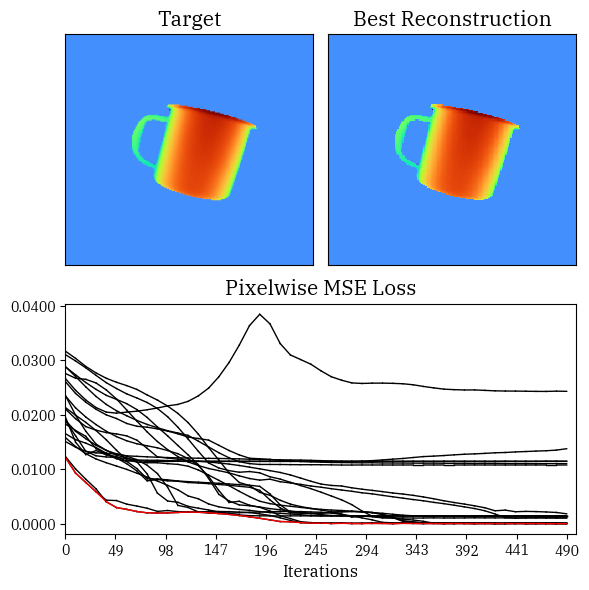

In [31]:
# make plot
import copy
cmap  = copy.copy(plt.get_cmap('turbo'))
cmap.set_bad(color=(1.0, 1.0, 1.0, 1.0))

it = ITERS

fig, (ax_target, ax_recon, ax_loss) = target_reconstruction_err_plot(it-1)
OPTIM_GIF_IMGS = []
assert len(AX_RECON_DATA) == len(AX_L_DATA) == len(RENDER_IMGS_DATA)
num_hypo = len(AX_L_DATA[0][0])

stepsize = max(1, it//50)
for i in tqdm(range(0,it,stepsize)):
    ax_target.imshow(AX_TARGET_DATA[0], aspect='auto')
    ax_recon.imshow(AX_RECON_DATA[i], interpolation='nearest', aspect='auto')

    ax_loss.plot([i-stepsize, i], [AX_L_DATA[i-stepsize][0], AX_L_DATA[i][0]], 'k', linewidth=1)
    ax_loss.plot([i-stepsize, i], [AX_L_DATA[i-stepsize][1], AX_L_DATA[i][1]], 'r', linewidth=1)
    # temp_pt_l = ax_loss.scatter([i for _ in range(num_hypo)], AX_L_DATA[i][0], s=5**2, color='blue')
    
    curr_fig = fig2img(fig)
    OPTIM_GIF_IMGS.append(b.hstack_images([curr_fig, RENDER_IMGS_DATA[i]])) 
    # temp_pt_l.remove()
    
for _ in range(5): # hold at last iter
    OPTIM_GIF_IMGS.append(b.hstack_images([curr_fig, RENDER_IMGS_DATA[i]]))


In [ ]:
b.viz.make_gif_from_pil_images(OPTIM_GIF_IMGS, "render_imgs_fast.gif")